# Business Understanding

# Data Understanding

## Hypothesis Test 1

### Question

Is there a statistically significant difference in the percentage of A's given if a class starts before noon or after noon?

### Hypotheses

Null Hypothesis: There is no significant difference in the mean percentage of A's in the morning classes and afternoon classes.

Alternate Hypothesis: There is a significant difference in the mean percentage of A's in the morning and afternoon classes.

### Methodology
We select an alpha value of 0.05.

We will perform a two-tail, two-sample t-test on the data. If we find significance. We will perform a one-tail, two-sample t-test to look at directionality.

Class start and end time is listed in minutes from midnight.

### Import Necessary Libraries

In [1]:
import psycopg2
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
plt.style.use('seaborn')
import numpy as np
import scipy.stats as stats

np.random.seed(2019)

# Data Preparation

## Connect to UW- Madison PostgreSQL database

In [2]:
conn = psycopg2.connect("host=localhost,dbname=postgres,user=postgres")

cur = conn.cursor()

We are interested in the percentage of A's given in a specific course and section. While there are other grades such as "credit" and "incomplete", these grades are not given a GPA value and we will therefore ignore them and only use A-F grades. We also want to collect the start times of the classes. Finally, we want the section type as we want to make sure that we measure Lecture and Seminar classes as opposed to Independent/Field Studies and Labs/Discussions (which often contribute to a lecture class' grade).

In [3]:
group_and_as = """
SELECT 
  grade.a_count
, grade.ab_count
, grade.b_count
, grade.bc_count
, grade.c_count
, grade.d_count
, grade.f_count
, sched.start_time
, sect.section_type
, grade.course_offering_uuid
, grade.section_number
FROM 
  sections sect
INNER JOIN 
  schedules sched 
ON 
  sched.uuid = sect.schedule_uuid
INNER JOIN 
  grade_distributions grade 
ON 
  sect.number = grade.section_number 
AND 
  sect.course_offering_uuid = grade.course_offering_uuid;
"""

In [4]:
cur.execute(group_and_as)
df = pd.DataFrame(cur.fetchall())
df.columns = [i[0] for i in cur.description]
df['total_count'] = (df['a_count'] + df['ab_count'] + df['b_count'] + df['bc_count'] 
                     + df['c_count'] + df['d_count'] + df['f_count'])
df.head()

,a_count,ab_count,b_count,bc_count,c_count,d_count,f_count,start_time,section_type,course_offering_uuid,section_number,total_count
0,0,0,0,0,0,0,0,-1,FLD,eb6254ad-776c-3830-9a85-0684665c1457,14,0
1,0,0,0,0,0,0,0,-1,FLD,94d362f0-53b2-33d0-85ca-4770d1371c97,10,0
2,35,0,1,0,0,0,0,960,LAB,e1a0631e-6efc-3021-a20d-a4a92081b754,1,36
3,39,1,0,1,0,0,0,725,LAB,c939dd5e-43ba-3266-8f74-573f629de75b,4,41
4,32,2,1,1,0,0,0,595,LAB,5c0652d8-d118-3652-8cbe-16b4a589aa03,2,36


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 217399 entries, 0 to 217398
Data columns (total 12 columns):
a_count                 217399 non-null int64
ab_count                217399 non-null int64
b_count                 217399 non-null int64
bc_count                217399 non-null int64
c_count                 217399 non-null int64
d_count                 217399 non-null int64
f_count                 217399 non-null int64
start_time              217399 non-null int64
section_type            217399 non-null object
course_offering_uuid    217399 non-null object
section_number          217399 non-null int64
total_count             217399 non-null int64
dtypes: int64(10), object(2)
memory usage: 19.9+ MB


There are 217,399 individual courses and section combinations.

In [6]:
df.sort_values(by='start_time').head()

,a_count,ab_count,b_count,bc_count,c_count,d_count,f_count,start_time,section_type,course_offering_uuid,section_number,total_count
0,0,0,0,0,0,0,0,-1,FLD,eb6254ad-776c-3830-9a85-0684665c1457,14,0
117776,0,0,0,0,0,0,0,-1,IND,872a8a2c-dcac-37cb-8a7a-be16263167be,21,0
117775,0,0,0,0,0,0,0,-1,IND,872a8a2c-dcac-37cb-8a7a-be16263167be,30,0
117774,0,0,0,0,0,0,0,-1,IND,872a8a2c-dcac-37cb-8a7a-be16263167be,97,0
117773,0,0,0,0,0,0,0,-1,IND,751a4179-840d-3947-8aff-29f274ec06cc,62,0


In [7]:
df.loc[df['start_time'] == -1, 'section_type'].value_counts()

IND    81726
LEC     4405
FLD     3691
SEM     1344
LAB     1331
DIS       19
Name: section_type, dtype: int64

All the independent studies are -1. As all these values are no use to our test (because we are interested in start time) we will drop all start_times of -1. We will also cut of irregular times (classes that start before 6AM) because these are potentially errors during input. We also want to drop any class type that is not lecture or seminar.

In [8]:
df = df[df['start_time'] >= 360]
df = df[df['section_type'] != 'IND']
df = df[df['section_type'] != 'FLD']
df = df[df['section_type'] != 'LAB']
df = df[df['section_type'] != 'DIS']
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 97441 entries, 35 to 217233
Data columns (total 12 columns):
a_count                 97441 non-null int64
ab_count                97441 non-null int64
b_count                 97441 non-null int64
bc_count                97441 non-null int64
c_count                 97441 non-null int64
d_count                 97441 non-null int64
f_count                 97441 non-null int64
start_time              97441 non-null int64
section_type            97441 non-null object
course_offering_uuid    97441 non-null object
section_number          97441 non-null int64
total_count             97441 non-null int64
dtypes: int64(10), object(2)
memory usage: 9.7+ MB


We now have 97,441 entries after dropping observations not relevant to our question. We then want to confirm that every class has students.

In [9]:
df.sort_values(by='total_count').head()

,a_count,ab_count,b_count,bc_count,c_count,d_count,f_count,start_time,section_type,course_offering_uuid,section_number,total_count
169585,0,0,0,0,0,0,0,780,LEC,bb47c545-44b7-3a35-9810-5d621db8057b,29,0
39641,0,0,0,0,0,0,0,780,LEC,9a99e814-e7ec-3a06-a42a-eeaaf336d543,6,0
39640,0,0,0,0,0,0,0,780,LEC,27e91550-b510-3c59-b48e-92b57496b98e,4,0
39639,0,0,0,0,0,0,0,780,LEC,e8f080b2-ef22-3639-a4b1-7243c784c843,2,0
156356,0,0,0,0,0,0,0,480,SEM,fa6897f6-d432-3fae-9672-8b023b93fee6,7,0


There are still a number of classes that have no students. We want to drop these as it is not reflective of our study.

In [10]:
df = df[df['total_count'] != 0]

In [11]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 85173 entries, 35 to 217233
Data columns (total 12 columns):
a_count                 85173 non-null int64
ab_count                85173 non-null int64
b_count                 85173 non-null int64
bc_count                85173 non-null int64
c_count                 85173 non-null int64
d_count                 85173 non-null int64
f_count                 85173 non-null int64
start_time              85173 non-null int64
section_type            85173 non-null object
course_offering_uuid    85173 non-null object
section_number          85173 non-null int64
total_count             85173 non-null int64
dtypes: int64(10), object(2)
memory usage: 8.4+ MB


We now have 85,173 classes.

In [12]:
df2 = df.copy()

In [13]:
# create ratio column
df2['ratio_of_as'] = df['a_count'] / df['total_count']

In [14]:
df2.drop_duplicates(inplace=True)
df2.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 70987 entries, 35 to 217232
Data columns (total 13 columns):
a_count                 70987 non-null int64
ab_count                70987 non-null int64
b_count                 70987 non-null int64
bc_count                70987 non-null int64
c_count                 70987 non-null int64
d_count                 70987 non-null int64
f_count                 70987 non-null int64
start_time              70987 non-null int64
section_type            70987 non-null object
course_offering_uuid    70987 non-null object
section_number          70987 non-null int64
total_count             70987 non-null int64
ratio_of_as             70987 non-null float64
dtypes: float64(1), int64(10), object(2)
memory usage: 7.6+ MB


Dropping any potential duplicates reduces classes to 70,987

/Users/kaylischulz/anaconda3/envs/learn-env/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


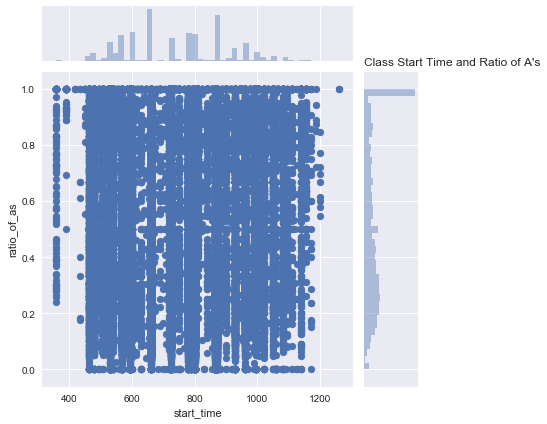

In [15]:
sns.jointplot('start_time', 'ratio_of_as',df2);
plt.title("Class Start Time and Ratio of A's", loc='left')
plt.show()

The start times of classes appear to be very spread. Whereas there is much more classes that give a high proportion of A's to lower proportions of A's.

Create separate dataframes for AM and PM classes.

In [16]:
morning_df = df2.loc[df['start_time'] < 720]
afternoon_df = df2.loc[df['start_time'] >= 720]

In [17]:
morning_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 31901 entries, 36 to 217232
Data columns (total 13 columns):
a_count                 31901 non-null int64
ab_count                31901 non-null int64
b_count                 31901 non-null int64
bc_count                31901 non-null int64
c_count                 31901 non-null int64
d_count                 31901 non-null int64
f_count                 31901 non-null int64
start_time              31901 non-null int64
section_type            31901 non-null object
course_offering_uuid    31901 non-null object
section_number          31901 non-null int64
total_count             31901 non-null int64
ratio_of_as             31901 non-null float64
dtypes: float64(1), int64(10), object(2)
memory usage: 3.4+ MB


In [18]:
afternoon_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 39086 entries, 35 to 217204
Data columns (total 13 columns):
a_count                 39086 non-null int64
ab_count                39086 non-null int64
b_count                 39086 non-null int64
bc_count                39086 non-null int64
c_count                 39086 non-null int64
d_count                 39086 non-null int64
f_count                 39086 non-null int64
start_time              39086 non-null int64
section_type            39086 non-null object
course_offering_uuid    39086 non-null object
section_number          39086 non-null int64
total_count             39086 non-null int64
ratio_of_as             39086 non-null float64
dtypes: float64(1), int64(10), object(2)
memory usage: 4.2+ MB


There are 31,901 morning classes and 39,086 afternoon classes.

### Determine Sample Size

In [19]:
moe = 0.1
z = 1.96 # z value for alpha 0.05
morn_var = np.var(morning_df['ratio_of_as'])
morn_n = len(morning_df['ratio_of_as'])
aft_var = np.var(afternoon_df['ratio_of_as'])
aft_n = len(afternoon_df['ratio_of_as'])

num = (morn_n - 1) * morn_var + (aft_n - 1) * aft_var
den = morn_n + aft_n - 2
pooled_std = np.sqrt(num/den)

In [20]:
n = 2 * (z * pooled_std / moe)**2
n

65.23057524944512

We will use samples from morning and afternoon of size 68.

In [21]:
morning = morning_df['ratio_of_as']
afternoon = afternoon_df['ratio_of_as']

morning_sample = np.random.choice(morning, size=66)
afternoon_sample = np.random.choice(afternoon, size=66)

In [22]:
stats.ttest_ind(morning_sample, afternoon_sample)

Ttest_indResult(statistic=-1.765404783167222, pvalue=0.07984364969272358)

Our p-value is about 0.127 which is greater than our halved-alpha of 0.025 (since a two-tailed test). This means that we cannot reject the null hypothesis. We cannot say that there is a statistical difference in the ratio of A's of a class depending on if the class is before or after noon. 

If we want to improve our schedules to increase the percentage of A's we will need to look at other factors.